In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=a7ec4985ce2a1e835681870d64cc624aedf4e52585e9ac8cc90d4bed945cb3ab
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# https://drive.google.com/file/d/17y6tyGP_4MoPsdpxOToNXSlsNN42S6mD/view?usp=share_link 

# Load Data

In [ ]:
# Helper Functions
def rolling_mean(df, col_name, window_size):
    rolling_mean = df[col_name].rolling(window_size).mean()
    df[f"Mean of {col_name} for {window_size} days"] = rolling_mean
    return df

def rolling_std(df, col_name, window_size):
    rolling_mean = df[col_name].rolling(window_size).std()
    df[f"Std of {col_name} for {window_size} days"] = rolling_mean
    return df

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col
from pyspark.pandas.window import Rolling
import pyspark.sql.functions as f

# create a SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("DSW_Final_Project").getOrCreate()

# mount your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# # set the file path
file_id = '17y6tyGP_4MoPsdpxOToNXSlsNN42S6mD'
url = f'https://drive.google.com/uc?id={file_id}'
spark.sparkContext.addFile(url)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Mounted at /content/drive


# Tweet Sentiment Analysis

In [ ]:
# download the file from Google Drive to Colab

ts_file_path = '/content/drive/MyDrive/BTC_Prices.csv'
tw_file_path = '/content/drive/MyDrive/mbsa.csv'


# read the file into a Spark DataFrame
time_series_df = spark.read.format("csv").option("sep", "\t").option("header", "true").load(ts_file_path)

In [ ]:
import re    # RegEx for removing non-letter characters
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType


# Function to remove URLs from text
def remove_urls(text):
     # Regular expression to match URLs
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_regex, '', text)

remove_urls_udf = udf(lambda x:remove_urls(x),StringType())

In [ ]:
startDate = "2017-01-02" 
endDate = "2019-01-01" 

In [ ]:
from pyspark.sql.functions import col, to_date, unix_timestamp
spark.sql("set spark.sql.legacy.timeParserPolicy=CORRECTED")

tweets_spark_df = spark.read.format("csv").option("header", "true").load(tw_file_path) #.option("sep", ";")
tweets_spark_df = tweets_spark_df.na.drop("any")
tweets_spark_df = tweets_spark_df.withColumn("Date", to_date(unix_timestamp('Date', 'yyyy-MM-dd').cast("timestamp"))).filter(col('Date').isNotNull())
tweets_spark_df = tweets_spark_df.withColumn("clean_text", remove_urls_udf(tweets_spark_df.text))

tweets_spark_df = tweets_spark_df.filter(col("Date").between(startDate, endDate))

tweets_spark_df.show(10)

+----------+--------------------+---------+--------------------+
|      Date|                text|Sentiment|          clean_text|
+----------+--------------------+---------+--------------------+
|2018-09-11|#BTCUSD Market #1...| Negative|#BTCUSD Market #1...|
|2018-09-11|100.00$ = 15,79 B...| Negative|100.00$ = 15,79 B...|
|2018-09-11|Find the best Bit...| Negative|Find the best Bit...|
|2018-09-11|11 Septiembre, 20...| Negative|11 Septiembre, 20...|
|2018-09-11|Sep 11, 2018 20:0...| Negative|Sep 11, 2018 20:0...|
|2018-09-11|Gunakan link unda...| Negative|Gunakan link unda...|
|2018-09-11|Sep 11, 2018 23:3...| Negative|Sep 11, 2018 23:3...|
|2018-09-11|Sign up using my ...| Negative|Sign up using my ...|
|2018-09-11|12 Eylül 2018 Saa...| Negative|12 Eylül 2018 Saa...|
|2018-09-11|Sep 11, 2018 23:0...| Negative|Sep 11, 2018 23:0...|
+----------+--------------------+---------+--------------------+
only showing top 10 rows



In [ ]:
tweets_spark_df.count()

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56550)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/lib/python3.10/dist-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError


In [ ]:
# # tweets_spark_df = tweets_spark_df.withColumn("user_followers",tweets_spark_df.user_followers.cast('int'))
# # tweets_spark_df = tweets_spark_df.filter(tweets_spark_df.user_followers > 0)
# tweets_spark_df = tweets_spark_df.filter(tweets_spark_df.text.isNotNull())
# tweets_spark_df = tweets_spark_df.withColumn("Date", to_date(unix_timestamp('Date', 'yyyy-MM-dd').cast("timestamp"))).filter(col('Date').isNotNull())
# # tweets_spark_df = tweets_spark_df.filter(col("date").between(startDate, endDate))
# tweets_spark_df = tweets_spark_df.withColumn("clean_text", remove_urls_udf(tweets_spark_df.text))
# tweets_spark_df.count()

Py4JJavaError: ignored

In [ ]:
tweets_spark_df.select('date').distinct().count()

222

In [ ]:
selected_tweets_spark_df = tweets_spark_df.select('date', 'clean_text')
# selected_tweets_spark_df.show()

In [ ]:
# selected_tweets_spark_df.agg({'date': 'min'}).show()
# selected_tweets_spark_df.agg({'date': 'max'}).show()

+----------+
| min(date)|
+----------+
|2021-07-30|
+----------+



ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.4 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

# Load the BERT sentiment analysis pipeline
sentiment_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

def extract_sentiment(text):
    return sentiment_classifier(text, truncation=True, padding=True)[0]['score']

extract_sentiment_udf = udf(lambda x:extract_sentiment(x),StringType())

es_tweets_spark_df = tweets_spark_df.withColumn("sentiment_score", extract_sentiment_udf(selected_tweets_spark_df.clean_text))

# Perform sentiment analysis on each row of text in the 'cleantext' column
# sentiment_predictions = sentiment_classifier(tweets_spark_df['clean_text'], truncation=True, padding=True)


In [ ]:
es_tweets_spark_df = es_tweets_spark_df.withColumn("sentiment_score", col('sentiment_score').cast('double'))
es_tweets_spark_df = es_tweets_spark_df.groupBy("date").mean("sentiment_score")

In [ ]:
es_tweets_df = es_tweets_spark_df.toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
pandas_es_tweet_df = rolling_mean(es_tweets_df, "avg(sentiment_score)", 3)
pandas_es_tweet_df = rolling_mean(es_tweets_df, "avg(sentiment_score)", 7)
pandas_es_tweet_df = rolling_mean(es_tweets_df, "avg(sentiment_score)", 30)
pandas_es_tweet_df = rolling_std(es_tweets_df, "avg(sentiment_score)", 3)
pandas_es_tweet_df = rolling_std(es_tweets_df, "avg(sentiment_score)", 7)
pandas_es_tweet_df = rolling_std(es_tweets_df, "avg(sentiment_score)", 30)

In [ ]:
display(pandas_es_tweet_df)

,date,avg(sentiment_score),Mean of avg(sentiment_score) for 3 days,Mean of avg(sentiment_score) for 7 days,Mean of avg(sentiment_score) for 30 days,Std of avg(sentiment_score) for 3 days,Std of avg(sentiment_score) for 7 days,Std of avg(sentiment_score) for 30 days
0,2021-07-30,0.756336,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-21,0.724039,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-20,0.755521,0.745299,NaN,NaN,0.018416,NaN,NaN
3,2021-08-04,0.854390,0.777983,NaN,NaN,0.068017,NaN,NaN
4,2021-08-08,0.762190,0.790700,NaN,NaN,0.055258,NaN,NaN
...,...,...,...,...,...,...,...,...
155,2022-11-13,0.685689,0.741800,0.718251,0.721890,0.050483,0.040193,0.024491
156,2023-01-06,0.757114,0.732992,0.727672,0.722504,0.040969,0.040514,0.025148
157,2023-01-07,0.788112,0.743638,0.735691,0.724713,0.052525,0.046606,0.027853
158,2023-01-09,0.739906,0.761711,0.744817,0.724567,0.024429,0.038530,0.027758


In [ ]:
len(pandas_es_tweet_df.index)

In [ ]:
rw_es_tweets_spark_df = spark.createDataFrame(pandas_es_tweet_df)

In [ ]:
rw_es_tweets_spark_df.columns

['date',
 'avg(sentiment_score)',
 'Mean of avg(sentiment_score) for 3 days',
 'Mean of avg(sentiment_score) for 7 days',
 'Mean of avg(sentiment_score) for 30 days',
 'Std of avg(sentiment_score) for 3 days',
 'Std of avg(sentiment_score) for 7 days',
 'Std of avg(sentiment_score) for 30 days']

# Time Series

In [ ]:
# replace dollar signs with an empty string in the dollar columns
dollar_cols = ["Open*", "High", "Low", "Close**", "Volume", "Market Cap"]
for col in dollar_cols:
    time_series_df = time_series_df.withColumn(col, f.regexp_replace(col, "\$", ""))
    time_series_df = time_series_df.withColumn(col, f.regexp_replace(col, ",", ""))
    time_series_df = time_series_df.withColumn(col, time_series_df[col].cast("float"))

# convert PySpark DataFrame to Pandas DataFrame
pandas_time_series_df = time_series_df.toPandas()

# Rolling Means

pandas_time_series_df = rolling_mean(pandas_time_series_df, "Open*", 3)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Open*", 7)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Open*", 30)

pandas_time_series_df = rolling_mean(pandas_time_series_df, "Close**", 3)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Close**", 7)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Close**", 30)

pandas_time_series_df = rolling_mean(pandas_time_series_df, "Volume", 3)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Volume", 7)
pandas_time_series_df = rolling_mean(pandas_time_series_df, "Volume", 30)

# Rolling STDs

pandas_time_series_df = rolling_std(pandas_time_series_df, "Open*", 3)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Open*", 7)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Open*", 30)

pandas_time_series_df = rolling_std(pandas_time_series_df, "Close**", 3)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Close**", 7)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Close**", 30)

pandas_time_series_df = rolling_std(pandas_time_series_df, "Volume", 3)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Volume", 7)
pandas_time_series_df = rolling_std(pandas_time_series_df, "Volume", 30)

# Avg Price and Previous Day Avg price
# pandas_time_series_df['Avg Price'] = (pandas_time_series_df['High'] + pandas_time_series_df['Low']) / 2
# pandas_time_series_df['Prev Day Avg Price'] = pandas_time_series_df['Avg Price'].shift(1)

#  Previous Day close price
pandas_time_series_df['Prev Day Close Price'] = pandas_time_series_df['Close**'].shift(1)
pandas_time_series_df['Next Day Close Price'] = pandas_time_series_df['Close**'].shift(-1)

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
time_series_spark_df = spark.createDataFrame(pandas_time_series_df)

In [ ]:
from pyspark.sql.functions import col
time_series_spark_df = time_series_spark_df.withColumn("Date", to_date(unix_timestamp('date', 'MMM dd, yyyy').cast("timestamp"))).filter(col("Date").between(startDate, endDate))

# clean_spark_df.show()
# clean_spark_df.agg({'Date': 'min'}).show()
# clean_spark_df.agg({'Date': 'max'}).show()

In [ ]:
joined_spark_df = time_series_spark_df.join(rw_es_tweets_spark_df,time_series_spark_df.Date ==  rw_es_tweets_spark_df.date,"inner").drop(rw_es_tweets_spark_df.date)

In [ ]:
joined_spark_df = joined_spark_df.na.drop("any")
joined_spark_df.count()

In [ ]:
input_features = [col.name for col in joined_spark_df.schema if col.name != 'Date' and col.name != 'Next Day Close Price']
print(len(input_features))

In [ ]:
assembler = VectorAssembler(
    inputCols=input_features,
    outputCol="features")

featurized_spark_df = assembler.transform(joined_spark_df)
featurized_spark_df

In [ ]:
featurized_spark_df.show(truncate=False)

+----------+--------------+--------------+--------------+--------------+---------------+-----------------+------------------------+------------------------+-------------------------+--------------------------+--------------------------+---------------------------+-------------------------+-------------------------+--------------------------+-----------------------+-----------------------+------------------------+-------------------------+-------------------------+--------------------------+------------------------+------------------------+-------------------------+--------------------+--------------------+--------------------+---------------------------------------+---------------------------------------+----------------------------------------+--------------------------------------+--------------------------------------+---------------------------------------+-------------------------------------------------------------------------------------------------------------------------------

# Data from EMR
Do not run above cells if you are running from EMR preprocessed data

In [ ]:
data_file_path = '/content/drive/MyDrive/emr_data.csv'


# read the file into a Spark DataFrame
data_spark_df = spark.read.format("csv").option("sep", ",").option("header", "true").load(data_file_path)
data_spark_df.select(col("date"), col("close"), col("Next Day Close Price")).show(10)

+----------+-------+--------------------+
|      date|  close|Next Day Close Price|
+----------+-------+--------------------+
|2017-01-31|970.403|             989.023|
|2017-02-01|989.023|              1011.8|
|2017-02-02| 1011.8|             1029.91|
|2017-02-03|1029.91|              1042.9|
|2017-02-04| 1042.9|             1027.34|
|2017-02-05|1027.34|             1038.15|
|2017-02-06|1038.15|             1061.35|
|2017-02-07|1061.35|             1063.07|
|2017-02-08|1063.07|             994.383|
|2017-02-09|994.383|             988.674|
+----------+-------+--------------------+
only showing top 10 rows



In [ ]:
sentiment_inputs = ['sentiment', 'Mean of sentiment for 3 days', 'Mean of sentiment for 7 days', 'Mean of sentiment for 30 days', 'Std of sentiment for 3 days', 'Std of sentiment for 7 days', 'Std of sentiment for 30 days']
input_features = [col.name for col in data_spark_df.schema if col.name != 'date' and col.name!= 'timestamp'  and col.name != 'Next Day Close Price'] # and col.name not in sentiment_inputs]
print(input_features)
print(len(input_features))

['open', 'high', 'low', 'close', 'volume', 'marketCap', 'Mean of open for 3 days', 'Mean of open for 7 days', 'Mean of open for 30 days', 'Mean of close for 3 days', 'Mean of close for 7 days', 'Mean of close for 30 days', 'Mean of volume for 3 days', 'Mean of volume for 7 days', 'Mean of volume for 30 days', 'Std of open for 3 days', 'Std of open for 7 days', 'Std of open for 30 days', 'Std of close for 3 days', 'Std of close for 7 days', 'Std of close for 30 days', 'Std of volume for 3 days', 'Std of volume for 7 days', 'Std of volume for 30 days', 'Prev Day Close Price', 'sentiment', 'Mean of sentiment for 3 days', 'Mean of sentiment for 7 days', 'Mean of sentiment for 30 days', 'Std of sentiment for 3 days', 'Std of sentiment for 7 days', 'Std of sentiment for 30 days']
32


In [ ]:
for col_name in input_features:
    data_spark_df = data_spark_df.withColumn(col_name, col(col_name).cast('float'))
data_spark_df = data_spark_df.withColumn('Next Day Close Price', col('Next Day Close Price').cast('float'))

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=input_features,
    outputCol="features")

featurized_spark_df = assembler.transform(data_spark_df)
featurized_spark_df.show()

+----------+-------+-------+-------+-------+------------+-------------+--------------------+-----------------------+-----------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+--------------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+------------------------+------------------------+------------------------+-------------------------+--------------------+--------------------+-----------+----------------------------+----------------------------+-----------------------------+---------------------------+---------------------------+----------------------------+--------------------+
|      date|   open|   high|    low|  close|      volume|    marketCap|           timestamp|Mean of open for 3 days|Mean of open for 7 days|Mean of open for 30 days|Mean of close for 3 days|Mean of close for 7 da

# XGBOOST



In [ ]:
!pip install --user virtualenv
!virtualenv xgboost_env
!python -m venv xgboost_env
!source /content/xgboost_env/bin/activate; pip install pyarrow pandas venv-pack xgboost
!source /content/xgboost_env/bin/activate; pip install cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!source /content/xgboost_env/bin/activate; venv-pack -o xgboost_env.tar.gz

from pyspark.ml.evaluation import RegressionEvaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 48.8 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
/bin/bash: virtualenv: command not found
Error: Command '['/content/xgboost_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: /content/xgboost_env/bin/activate: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: /content/xgboost_env/bin/activate: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not

In [ ]:
# Split dataset into train and test
from pyspark.sql.functions import unix_timestamp
# featurized_spark_df = featurized_spark_df.orderBy(unix_timestamp(featurized_spark_df["date"], "yyyy-MM-dd").cast("timestamp"))
train_spark_df, test_spark_df = featurized_spark_df.limit(int(featurized_spark_df.count()*.80)), featurized_spark_df.subtract(featurized_spark_df.limit(int(featurized_spark_df.count()*.80)))

In [ ]:
trainRows = train_spark_df.count()
print(f"Training Samples count : {trainRows}")
testRows = test_spark_df.count()
print(f"Testing Samples count : {testRows}")

Training Samples count : 560
Testing Samples count : 140


In [ ]:
# This is an XGBoost extension for GPU acceleration. On CPU, the convention established by the spark-ml library is used, where all features are stored in a single dataframe column

from xgboost.spark import SparkXGBRegressor
spark_reg_estimator = SparkXGBRegressor(
  features_col='features',
  label_col='Next Day Close Price',
  num_workers=1,
  use_gpu=True
)

## Hyperparameter Optimization

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from multiprocessing.pool import ThreadPool

def _parallelFitTasks(est, train, eva, validation, epm):
    modelIter = est.fitMultiple(train, epm)

    def singleTask():
        index, model = next(modelIter)
        metric = eva.evaluate(model.transform(validation, epm[index]))
        return index, metric

    return [singleTask] * len(epm)

def minimum(a,b):
  return  b if a > b else a


class CustomTrainValidationSplit(TrainValidationSplit):
    def _fit(self, dataset):
      est = self.getOrDefault(self.estimator)
      epm = self.getOrDefault(self.estimatorParamMaps)
      numModels = len(epm)
      eva = self.getOrDefault(self.evaluator)
      tRatio = self.getOrDefault(self.trainRatio)
      seed = self.getOrDefault(self.seed)
      randCol = self.uid + "_rand"
      train, validation = dataset.limit(int(dataset.count()*(tRatio))), dataset.subtract(dataset.limit(int(dataset.count()*(tRatio))))   
      trainRows = train.count()
      print(f"Train Samples count : {trainRows}")
      valRows = validation.count()
      print(f"Val Samples count : {valRows}")


      tasks = _parallelFitTasks(est, train, eva, validation, epm)
      pool = ThreadPool(processes= minimum(self.getParallelism(), numModels))
      metrics = [None] * numModels
      for j, metric in pool.imap_unordered(lambda f: f(), tasks):
          metrics[j] = metric
      train.unpersist()
      validation.unpersist()

      if eva.isLargerBetter():
          bestIndex = np.argmax(metrics)
      else:
          bestIndex = np.argmin(metrics)
      bestModel = est.fit(dataset, epm[bestIndex])
      return self._copyValues(TrainValidationSplitModel(bestModel, metrics))


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol=spark_reg_estimator.getLabelCol(),
                                predictionCol=spark_reg_estimator.getPredictionCol())

# Parameter grid search for xgboost

paramSearchGrid = (ParamGridBuilder()
             .addGrid(spark_reg_estimator.max_depth,[8])
             .addGrid(spark_reg_estimator.n_estimators, [100])
             .addGrid(spark_reg_estimator.gamma, [0.001])
             .addGrid(spark_reg_estimator.learning_rate, [0.1])
             .addGrid(spark_reg_estimator.base_score, [0.7])
             .build())


# paramSearchGrid = (ParamGridBuilder()
#              .addGrid(spark_reg_estimator.max_depth,[4, 6, 8])
#              .addGrid(spark_reg_estimator.n_estimators, [100, 200, 300])
#              .addGrid(spark_reg_estimator.gamma, [0.001, 0.01, 0.1])
#              .addGrid(spark_reg_estimator.learning_rate, [0.001, 0.01, 0.1])
#              .addGrid(spark_reg_estimator.base_score, [0.3, 0.5, 0.7])
#              .build())

# Grid search settings from the paper
# paramSearchGrid = (ParamGridBuilder()
#              .addGrid(spark_reg_estimator.max_depth,[2, 3, 4, 5, 6, 7, 8, 10])
#              .addGrid(spark_reg_estimator.n_estimators, [50, 100, 200])
#              .addGrid(spark_reg_estimator.gamma, [0, 0.001, 0.01, 0.1])
#              .addGrid(spark_reg_estimator.learning_rate, [0.001, 0.01, 0.1, 0.15, 0.2])
#              .addGrid(spark_reg_estimator.base_score, [0.3, 0.5, 0.7])
#              .build())


print("Number of combinations:", len(paramSearchGrid))


cv = CustomTrainValidationSplit(estimator=spark_reg_estimator, estimatorParamMaps=paramSearchGrid, evaluator=evaluator, trainRatio=0.8)
xgb_regressor_model = cv.fit(train_spark_df)

Number of combinations: 1
Train Samples count : 448


Val Samples count : 112


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [ ]:
# xgb_regressor_model.bestModel.get_booster().save_model("bestXGBModel.json")
xgb_regressor_model.bestModel.save("/tmp/best_model243e")
xgb_regressor_model.bestModel.extractParamMap()
bestModel = xgb_regressor_model.bestModel


## Retrieve Best Model

In [ ]:
from xgboost.spark.core import SparkXGBRegressorModel

bestModel = SparkXGBRegressorModel.load("/tmp/best_model243e")

In [ ]:
# Print the best params
bestModel.extractParamMap()

{Param(parent='SparkXGBRegressorModel_7766fc74dd83', name='arbitrary_params_dict', doc='arbitrary_params_dict This parameter holds all of the additional parameters which are not exposed as the the XGBoost Spark estimator params but can be recognized by underlying XGBoost library. It is stored as a dictionary.'): {},
 Param(parent='SparkXGBRegressorModel_7766fc74dd83', name='base_score', doc='Refer to XGBoost doc of xgboost.sklearn.XGBRegressor for this param base_score'): 0.7,
 Param(parent='SparkXGBRegressorModel_7766fc74dd83', name='booster', doc='Refer to XGBoost doc of xgboost.sklearn.XGBRegressor for this param booster'): None,
 Param(parent='SparkXGBRegressorModel_7766fc74dd83', name='callbacks', doc='Refer to XGBoost doc of xgboost.sklearn.XGBRegressor.fit() for this param callbacksThe callbacks can be arbitrary functions. It is saved using cloudpickle which is not a fully self-contained format. It may fail to load with different versions of dependencies.'): None,
 Param(parent=

In [ ]:
from pyspark.sql.functions import avg, lit

# Run model on test set
transformed_test_spark_dataframe = bestModel.transform(test_spark_df)

# Add a new column with the baseline (average value) to the DataFrame
baseline = train_spark_df.select(avg(col("Next Day Close Price"))).first()[0]
transformed_test_spark_dataframe = transformed_test_spark_dataframe.withColumn("Baseline (avrg)", lit(baseline))

# Results & Plotting

In [ ]:
from pyspark.sql.functions import col

transformed_test_spark_dataframe.select(col("date"), col("Next Day Close Price"), col("prediction"), col('Baseline (avrg)')).show()

+----------+--------------------+-----------------+-----------------+
|      date|Next Day Close Price|       prediction|  Baseline (avrg)|
+----------+--------------------+-----------------+-----------------+
|2018-08-29|             6978.23| 7189.15185546875|6085.542007882254|
|2018-11-09|             6409.22|  6553.6826171875|6085.542007882254|
|2018-12-23|            4078.599|    3900.89453125|6085.542007882254|
|2018-10-03|             6576.69|  6474.7841796875|6085.542007882254|
|2018-12-27|           3923.9187| 3902.81689453125|6085.542007882254|
|2018-08-16|             6580.63|   6571.150390625|6085.542007882254|
|2018-08-22|             6534.88|      6787.046875|6085.542007882254|
|2018-10-28|             6332.63|    6184.07421875|6085.542007882254|
|2018-09-25|              6495.0| 6657.05224609375|6085.542007882254|
|2018-08-15|             6334.73| 6450.32568359375|6085.542007882254|
|2018-10-06|             6602.95|     6423.3671875|6085.542007882254|
|2018-12-29|        

In [ ]:
from pyspark.sql.functions import *

ordered_transformed_test_spark_dataframe = transformed_test_spark_dataframe.orderBy(unix_timestamp(transformed_test_spark_dataframe["Date"], "yyyy-MM-dd").cast("timestamp"))
ordered_transformed_test_spark_dataframe.select(col("date"), col("Next Day Close Price"), col("close")).show()
#unix_timestamp(transformed_test_spark_dataframe["Date"], "MMM dd, yyyy").cast("timestamp")

+----------+--------------------+-------+
|      date|Next Day Close Price|  close|
+----------+--------------------+-------+
|2018-08-14|             6308.52|6199.71|
|2018-08-15|             6334.73|6308.52|
|2018-08-16|             6580.63|6334.73|
|2018-08-17|             6423.76|6580.63|
|2018-08-18|             6506.07|6423.76|
|2018-08-19|             6308.53|6506.07|
|2018-08-20|             6488.76|6308.53|
|2018-08-21|             6376.71|6488.76|
|2018-08-22|             6534.88|6376.71|
|2018-08-23|             6719.96|6534.88|
|2018-08-24|             6763.19|6719.96|
|2018-08-25|             6707.26|6763.19|
|2018-08-26|             6884.64|6707.26|
|2018-08-27|             7096.28|6884.64|
|2018-08-28|             7047.16|7096.28|
|2018-08-29|             6978.23|7047.16|
|2018-08-30|             7037.58|6978.23|
|2018-08-31|             7193.25|7037.58|
|2018-09-01|             7272.72|7193.25|
|2018-09-02|             7260.06|7272.72|
+----------+--------------------+-

In [ ]:
ordered_transformed_test_spark_dataframe_pd = ordered_transformed_test_spark_dataframe.toPandas()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

renamed_ordered_transformed_test_spark_dataframe_pd = ordered_transformed_test_spark_dataframe_pd.rename(columns={"Next Day Close Price": "Actual", "prediction": "Prediction"})
plot_df = pd.melt(renamed_ordered_transformed_test_spark_dataframe_pd[["date", "Prediction", "Actual", "Baseline (avrg)"]], ['date'], var_name="Next Day Close Price", value_name="BTC Price ($)")


Text(0.5, 1.0, 'BTC Next Day Close Price ($)\nPredicted vs Actual\n')

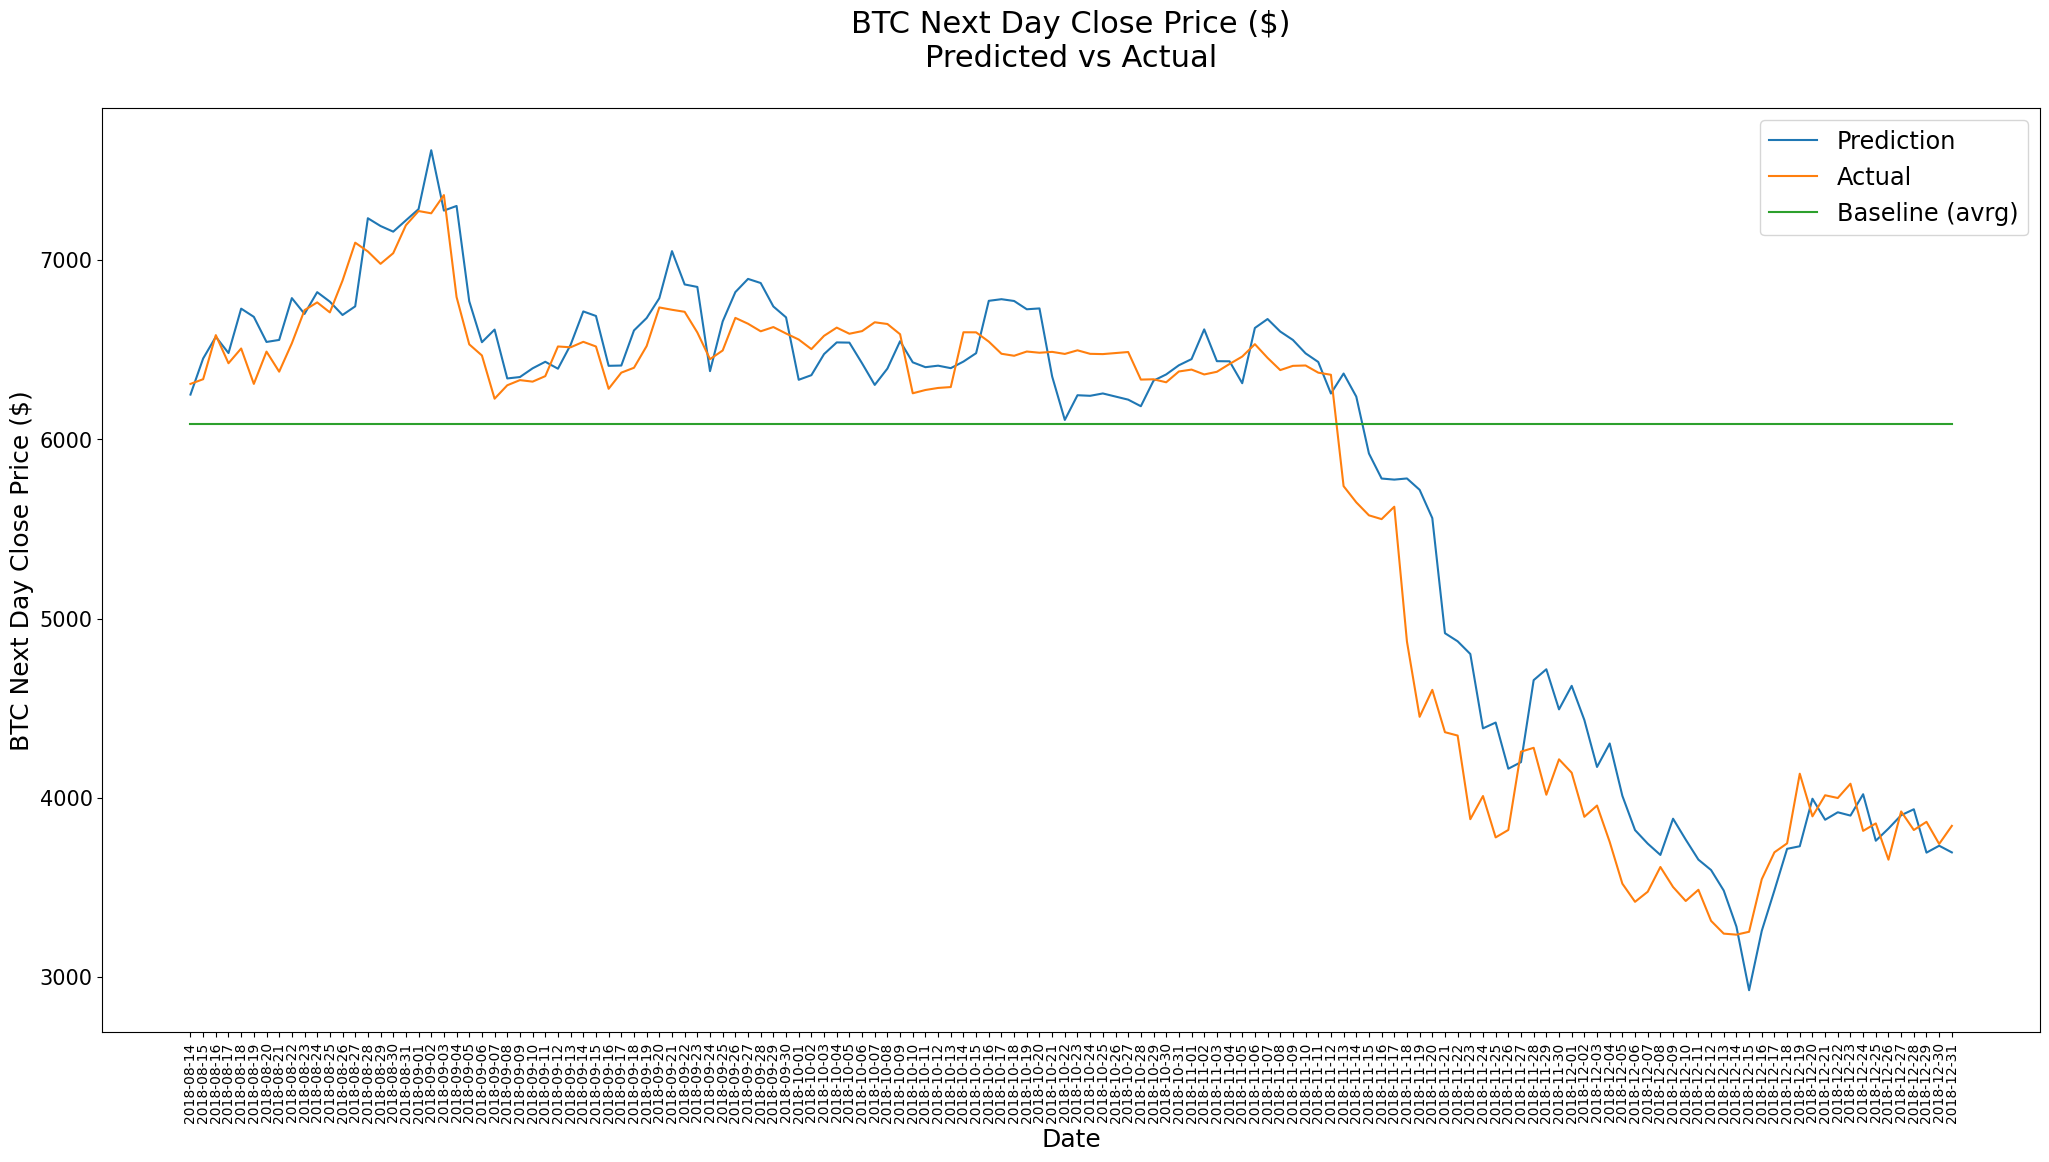

In [ ]:
fig = plt.figure(figsize=(25,12))
ax = sns.lineplot(x='date', y='BTC Price ($)', hue='Next Day Close Price', data=plot_df)
ax.tick_params(axis='x', labelrotation = 90)
plt.yticks(fontsize=15)
plt.xlabel('Date', fontsize=18)
plt.ylabel('BTC Next Day Close Price ($)', fontsize=18)
plt.legend(fontsize='xx-large')
plt.title("BTC Next Day Close Price ($)\nPredicted vs Actual\n", fontsize=22)

In [ ]:
model_feature_importance = bestModel.get_booster().get_score(importance_type='weight')
model_feature_importance_df = pd.DataFrame(model_feature_importance.items(), columns=['Feature_code', 'F-score'])
model_feature_importance_df['Feature_code'] = input_features


Text(0.5, 0, 'F-score')

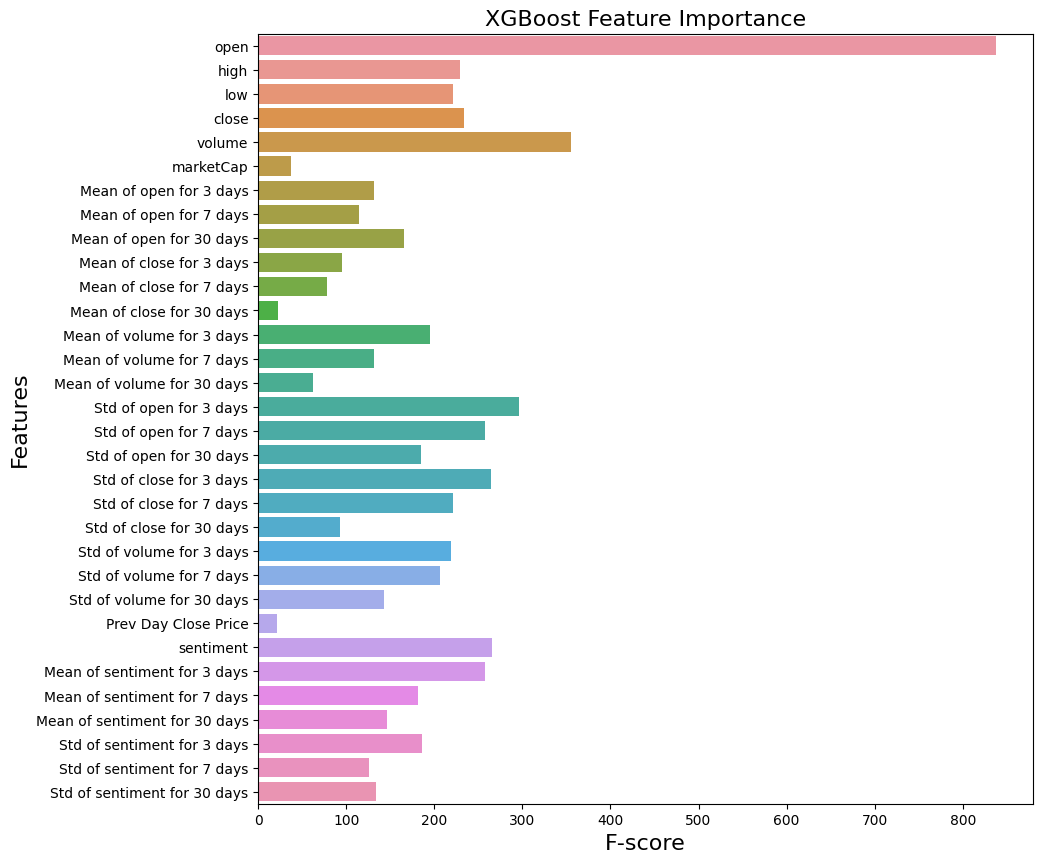

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y="Feature_code", x="F-score", data=model_feature_importance_df, orient='h')
# sns.despine(left=True, bottom=True)
plt.title("XGBoost Feature Importance", fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xlabel('F-score', fontsize=16)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Next Day Close Price", predictionCol="prediction")

rsquared = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "mae"})
rmse = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "rmse"})

print("Evaluation scores (XGBOOST)")
print("mae: ", mae)
print("rmse: ", rmse)
print("rsquared: ", rsquared)

Evaluation scores (XGBOOST)
mae:  223.25435093470983
rmse:  301.4650513759973
rsquared:  0.9434959962326342


In [ ]:
evaluator = RegressionEvaluator(labelCol="Next Day Close Price", predictionCol="Baseline (avrg)")

rsquared = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "mae"})
rmse = evaluator.evaluate(transformed_test_spark_dataframe, {evaluator.metricName: "rmse"})

print("Evaluation scores (Baseline)")
print("mae: ", mae)
print("rmse: ", rmse)
print("rsquared: ", rsquared)

Evaluation scores (Baseline)
mae:  1016.1422368512837
rmse:  1334.8618725423826
rsquared:  -0.10784227932381962
